# 0.0. IMPORTS

In [101]:
import math
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
import datetime
import matplotlib.gridspec as gridspec

## 0.1. Helper Functions

## 0.2. Loading Data

In [2]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

In [3]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
895732,58,5,2013-04-19,4826,451,1,0,0,0,a,c,7340.0,5.0,2008.0,1,27.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0. STEP 01 - DATA DESCRIPTION

In [4]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )


# rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types 

In [7]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA 

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA 

In [10]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan( x ) else x )

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [11]:
# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#ERRO MEIGAROM => month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:
df1.sample(5).T

,66503,107833,709540,408687,456274
store,719,794,71,268,1025
day_of_week,2,7,4,1,1
date,2015-06-02 00:00:00,2015-04-26 00:00:00,2013-10-03 00:00:00,2014-06-30 00:00:00,2014-05-19 00:00:00
sales,5847,0,0,8543,8918
customers,456,0,0,830,1059
open,1,0,0,1,1
promo,1,0,0,1,1
state_holiday,0,0,a,0,0
school_holiday,1,0,0,0,0
store_type,c,c,a,a,a


## 1.6. Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [15]:
# Central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\repos\anaconda3\envs\rossmann\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

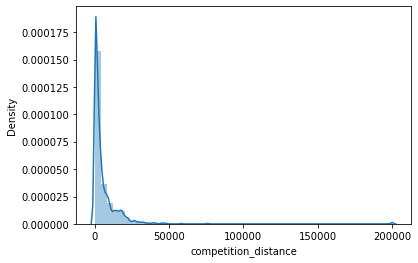

In [17]:
sns.distplot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [18]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

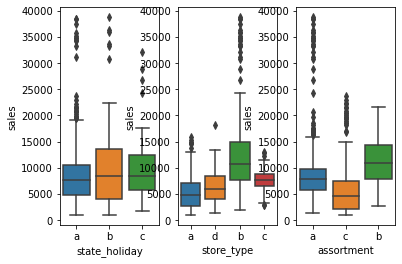

In [19]:
aux1 = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. STEP 02 - FEATURING ENGINEERING

In [20]:
df2 = df1.copy()

In [21]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
765397,178,3,2013-08-14,10340,923,1,1,0,1,d,a,1710.0,8,2013,0,33,2013,0,Aug,0


## 2.1. Mind Map Hypotheses

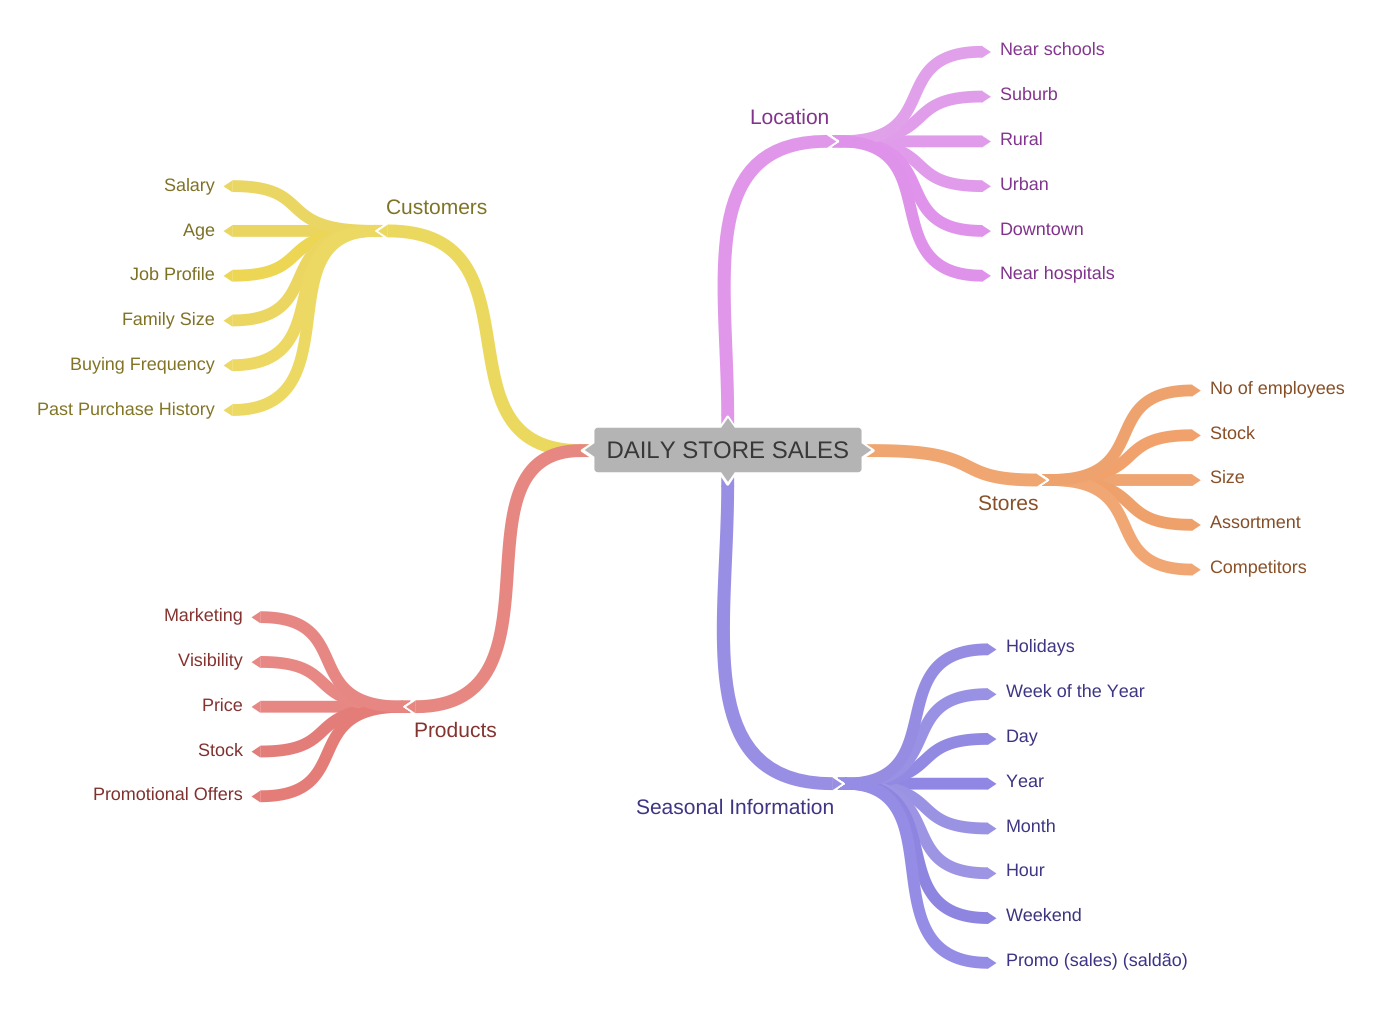

In [5]:
Image('img/MindMapHypotheses.png')

## 2.2. Hypotheses Creation

### 2.2.1 Hypotheses Store

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores há mais tempo deveriam vendem mais.

### 2.2.2 Hypotheses Product

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hypotheses Time

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Hypotheses Final List

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/ 30 ).apply( lambda x: x.days ).astype( int )

# promo_since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/ 7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday 
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

C:\Users\Leonardo de Freitas\AppData\Local\Temp\ipykernel_15508\1995858441.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [85]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. STEP 03 - FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

In [64]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


In [27]:
df3.shape

(1017209, 29)

## 3.1. Filtragem das Linhas

In [28]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

In [48]:
df3.shape

(844338, 25)

## 3.2. Seleção das Colunas

In [47]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

KeyError: "['customers', 'open', 'promo_interval', 'month_map'] not found in axis"

In [ ]:
df3.shape

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [32]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1. Response Variable

C:\repos\anaconda3\envs\rossmann\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

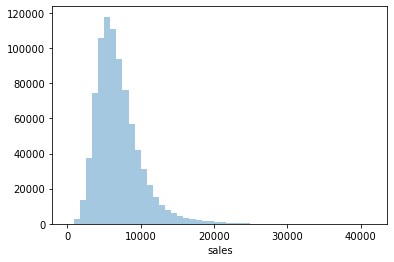

In [35]:
sns.distplot( df4['sales'], kde=False )

### 4.1.2. Numerical Variables

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

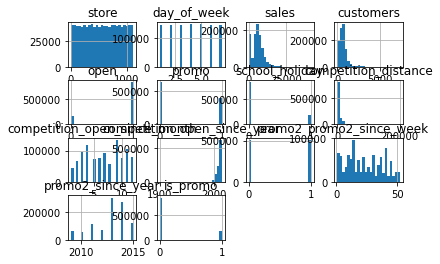

In [39]:
num_attributes.hist( bins=25 );

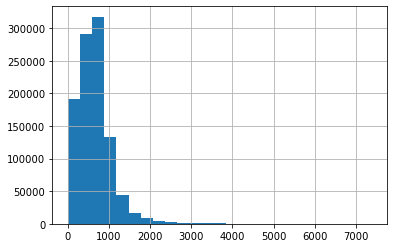

In [41]:
num_attributes['customers'].hist( bins=25 );

In [40]:
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


### 4.1.3. Categorical Variables

In [42]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [58]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [46]:
df4.shape

(844338, 25)

C:\repos\anaconda3\envs\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\repos\anaconda3\envs\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\repos\anaconda3\envs\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

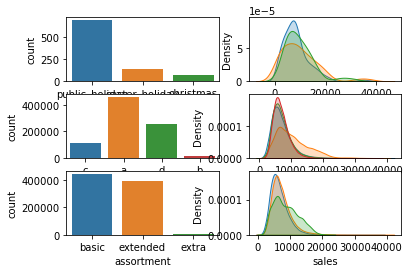

In [59]:
# state_holiday
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

C:\repos\anaconda3\envs\rossmann\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='state_holiday', ylabel='count'>

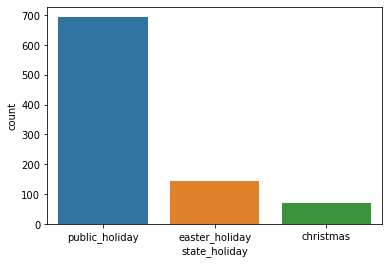

## 4.2. Análise Bivariada

### **H1.** Lojas com maior sortimento  deveriam vender mais.
** FALSA ** Lojas com MAIOR SORTIMENTO vendem MENOS.

<AxesSubplot:xlabel='year_week'>

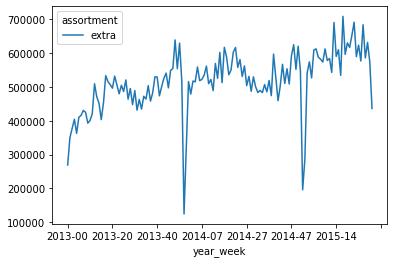

In [71]:
#aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales').plot()

In [69]:
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
** FALSA ** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS. 

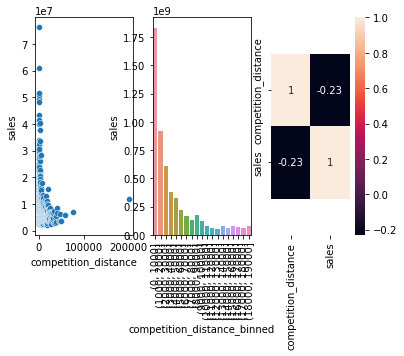

In [80]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
plt.xticks( rotation=90 )

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### **H3.** Lojas com competidores há mais tempo deveriam vendem mais.
** Falsa ** Lojas com COMPETIDORES HÁ MAIS TEMPO vendem MENOS.

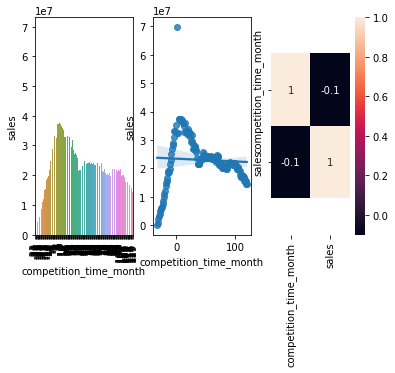

In [89]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
** FALSA ** Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

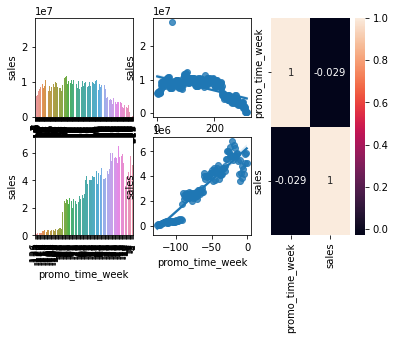

In [104]:
aux1= df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais. </s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
** FALSA ** Lojas com mais promoções consecutivas vendem menos.

In [106]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


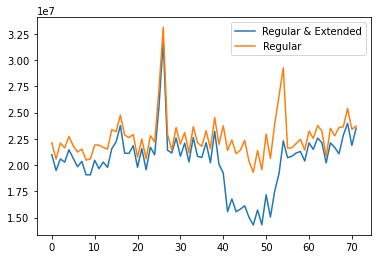

In [112]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Regular & Extended', 'Regular'] );

## 4.3. Análise Multivariada